# 测试学好的Q函数是否能表现得很好

实现目标：

1. 创建Agent， 并加载学习好的Q_net
2. 创建测试数据，使其可以分别输入IMM和Agent

In [1]:
import torch_geometric as tg

In [2]:
from Agent import Agent
from Env import env

import os

## 1. 加载Agent 

## 2.  数据生成

测试数据与训练数据同分布

In [3]:
from torch_geometric.data import Data
import torch
import numpy as np
import networkx as nx

## 3. Simulation 

In [4]:
def simulation_once(edge_index, edge_w, seed_list):
    import networkx as nx
    import ndlib.models.ModelConfig as mc
    import ndlib.models.epidemics as ep
    
    G = nx.DiGraph()
    G.add_edges_from(edge_index.T)
    
    model = ep.IndependentCascadesModel(G)
    
    # Model Configuration
    config = mc.Configuration()
    config.add_model_initial_configuration("Infected", seed_list)
    
    # Setting the edge parameters
    for e, w in zip(G.edges(), edge_w):
        config.add_edge_configuration("threshold", e, w)
    
    model.set_initial_status(config)
    
    while True:
        iteration = model.iteration()
        if iteration["node_count"][1] == 0:
            break
    
    return iteration["node_count"][2]

In [5]:
def simulation(edge_index, edge_w, seed_list, mc=100):
    from tqdm import tqdm
    import numpy as np
    from multiprocessing import Pool
    
    pool = Pool(50)
    spreads = []
    res = []
    for i in range(mc):
        res.append(pool.apply_async(simulation_once, (edge_index, edge_w, seed_list, )))
    
    pool.close()
    pool.join()
    
    for r in tqdm(res):
        spreads.append(r.get())
    return np.mean(spreads)

## 3. 方法比较 

In [6]:
def Q_infer(agent, graph, K):
    Seed = []
    for i in range(K):
        action = agent.choose_action(graph)
        Seed.append(action)
        graph.x[action] = 1
        
    return Seed

In [7]:
def before_IMM(edge_index, edge_w):
    import os
    import time
    G = nx.DiGraph()
    G.add_edges_from(edge_index.T)
    with open(".imm_cache/attribute.txt", "w") as f:
        f.writelines("n={}\nm={}".format(G.number_of_nodes(), G.number_of_edges()))
    with open(".imm_cache/graph_ic.inf", "w") as f:
        for edge, weight in zip(edge_index.T, edge_w):
            f.writelines("{} {} {:.3f}\n".format(edge[0], edge[1], weight[0]))

In [8]:
def IMM_infer(K):
    imm_red = os.popen("./IMM/imm_discrete -dataset .imm_cache/ -k {} -model IC -epsilon 0.1".format(K))
    
    Seed = []
    Spread = 0
    for line in imm_red:
        if "opt_lower_bound" in line:
            Spread = float(line.split("=")[1].strip())
        if "seedSet" in line:
            seed_set = line.split("=")[1].strip().split(" ")
            Seed = [int(s) for s in seed_set]
    
    return Seed, Spread

### 测试1， 相同大小的网络

In [9]:
import matplotlib.pyplot as plt

In [10]:
agent = Agent(test=True)
agent.load_Q_net("checkpoints/Q_net.model")

In [12]:
# ER graph
Env = env(graph_size=100, seed_size=10, edge_weight=0.1, random_edge_weight=False)

edge_index, edge_weight, x, mu, _ = Env.reset()
graph = Data(edge_index = torch.LongTensor(edge_index),
             edge_weight = torch.Tensor(edge_weight),
             mu = torch.Tensor(mu),
             x = torch.Tensor(x))

IMM_K = []
Q_K = []
Random_K = []

K_range = range(1, 20,5)
before_IMM(edge_index, edge_weight)
degree = tg.utils.degree(graph.edge_index[0]).int().numpy()
node_by_degree = degree.argsort().tolist()[::-1]

for K in K_range:
    graph.x = torch.zeros_like(graph.x)
    
    random_seed = node_by_degree[:K]
    imm_seed, imm_spread = IMM_infer(K=K)
    q_seed = Q_infer(agent, graph, K=K)

    imm_simu = simulation(edge_index, edge_weight, imm_seed, mc=500)
    random_simu = simulation(edge_index, edge_weight, random_seed, mc=500)
    q_simu = simulation(edge_index, edge_weight, q_seed, mc=500)
    print(imm_simu, q_simu, random_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    Random_K.append((random_seed, random_simu))

100%|██████████| 500/500 [00:00<00:00, 394646.59it/s]


13.912 4.314 14.034


100%|██████████| 500/500 [00:00<00:00, 269487.54it/s]


27.766 17.936 28.124


100%|██████████| 500/500 [00:00<00:00, 263560.64it/s]


35.89 29.69 34.598


100%|██████████| 500/500 [00:00<00:00, 376576.05it/s]

42.192 37.816 39.958


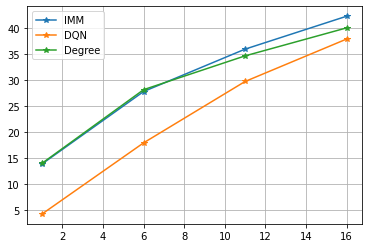

In [13]:
plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.plot(K_range, [s[1] for s in Random_K], "-*")
plt.legend(["IMM", "DQN", "Degree"])
plt.grid(True)
plt.show()

In [14]:
sorted(IMM_K[1][0])

[4, 5, 6, 8, 15, 18]

In [15]:
sorted(Q_K[1][0])

[72, 73, 96, 97, 98, 99]

In [16]:
sorted(Random_K[1][0])

[4, 5, 6, 7, 8, 15]

# 在真实的数据上测试 

In [19]:
def load_data(path):
    edge_index = []
    edge_weight = []
    n = m = 0
    with open(path, "r") as f:
        for line in f:
            line_list = line.strip().split(" ")
            if len(line_list) == 2:
                n, m = [int(x) for x in line_list]
            else:
                edge_index.append([int(x) for x in line_list[:2]])
                edge_weight.append([float(line_list[-1])])
    return n, m, np.array(edge_index).T, np.array(edge_weight)

In [20]:
n, m, edge_index, edge_weight = load_data("./data/Twitter.txt")

In [21]:
graph = Data(edge_index = torch.LongTensor(edge_index),
               edge_weight = torch.Tensor(edge_weight),
               x = torch.zeros((n,1)))

100%|██████████| 50/50 [00:00<00:00, 69580.36it/s]


17505.24 6697.36 17428.52


100%|██████████| 50/50 [00:00<00:00, 160701.30it/s]


17458.92 17535.28 17539.78


100%|██████████| 50/50 [00:00<00:00, 136711.34it/s]


17638.38 17419.42 17648.4


100%|██████████| 50/50 [00:00<00:00, 134778.41it/s]


17783.0 17654.56 17601.48


100%|██████████| 50/50 [00:00<00:00, 135825.91it/s]


17866.92 17540.4 17532.4


100%|██████████| 50/50 [00:00<00:00, 162192.73it/s]

18099.9 17489.68 17462.9


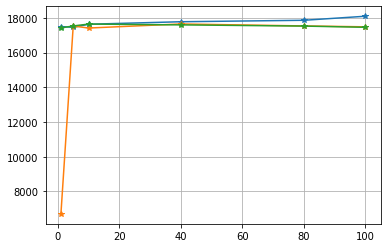

In [22]:
IMM_K = []
Q_K = []
Random_K = []

K_range = [1, 5, 10, 40, 80, 100]
before_IMM(edge_index, edge_weight)
degree = tg.utils.degree(graph.edge_index[0]).int().numpy()
node_by_degree = degree.argsort().tolist()[::-1]

for K in K_range:
    random_seed = node_by_degree[:K]
    imm_seed, imm_spread = IMM_infer(K=K)
    q_seed = Q_infer(agent, graph, K=K)

    imm_simu = simulation(edge_index, edge_weight, imm_seed, mc=50)
    random_simu = simulation(edge_index, edge_weight, random_seed, mc=50)
    q_simu = simulation(edge_index, edge_weight, q_seed, mc=50)
    print(imm_simu, q_simu, random_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    Random_K.append((random_seed, random_simu))
    

plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.plot(K_range, [s[1] for s in Random_K], "-*")
plt.grid(True)
plt.show()

100%|██████████| 50/50 [00:00<00:00, 142955.15it/s]


246.26 37.62 264.86


100%|██████████| 50/50 [00:00<00:00, 122425.69it/s]


609.48 254.72 430.2


100%|██████████| 50/50 [00:00<00:00, 131565.37it/s]


691.78 387.44 623.22


100%|██████████| 50/50 [00:00<00:00, 167772.16it/s]


1004.78 739.0 989.5


100%|██████████| 50/50 [00:00<00:00, 161567.95it/s]


1282.08 939.72 1178.96


100%|██████████| 50/50 [00:00<00:00, 113605.20it/s]

1415.2 1007.72 1268.88


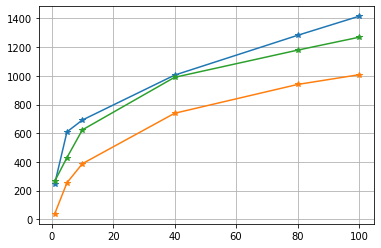

In [18]:
IMM_K = []
Q_K = []
Random_K = []

K_range = [1, 5, 10, 40, 80, 100]
before_IMM(edge_index, edge_weight)
degree = tg.utils.degree(graph.edge_index[0]).int().numpy()
node_by_degree = degree.argsort().tolist()[::-1]

for K in K_range:
    random_seed = node_by_degree[:K]
    imm_seed, imm_spread = IMM_infer(K=K)
    q_seed = Q_infer(agent, graph, K=K)

    imm_simu = simulation(edge_index, edge_weight, imm_seed, mc=50)
    random_simu = simulation(edge_index, edge_weight, random_seed, mc=50)
    q_simu = simulation(edge_index, edge_weight, q_seed, mc=50)
    print(imm_simu, q_simu, random_simu)
    
    IMM_K.append((imm_seed, imm_simu))
    Q_K.append((q_seed, q_simu))
    Random_K.append((random_seed, random_simu))
    

plt.plot(K_range, [s[1] for s in IMM_K], "-*")
plt.plot(K_range, [s[1] for s in Q_K], "-*")
plt.plot(K_range, [s[1] for s in Random_K], "-*")
plt.grid(True)
plt.show()